# Timeseries Data
Performed detailed data prepping and processing on image data

In [ ]:
!pip install h2o


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=1af16fdcb90c3ce8bbee40282409f256ab5eee8055ea634b55dd94989aa1fbff
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o


## Step 1: EDA

In [1]:
import pandas as pd

# Load the dataset
dataset_path = '/content/dataset.csv'
df = pd.read_csv(dataset_path)

# Show the first few rows of the dataset
df.head(), df.describe(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10320 non-null  int64 
 1   timestamp   10320 non-null  object
 2   value       10320 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 242.0+ KB


(   Unnamed: 0            timestamp  value
 0           0  2014-07-01 00:00:00  10844
 1           1  2014-07-01 00:30:00   8127
 2           2  2014-07-01 01:00:00   6210
 3           3  2014-07-01 01:30:00   4656
 4           4  2014-07-01 02:00:00   3820,
          Unnamed: 0         value
 count  10320.000000  10320.000000
 mean    5159.500000  15137.569380
 std     2979.271723   6939.495808
 min        0.000000      8.000000
 25%     2579.750000  10262.000000
 50%     5159.500000  16778.000000
 75%     7739.250000  19838.750000
 max    10319.000000  39197.000000,
 None)

# Step 2: Data Processing

In [2]:
# Drop the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Show the first few rows of the cleaned dataset and its information
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


(            timestamp  value
 0 2014-07-01 00:00:00  10844
 1 2014-07-01 00:30:00   8127
 2 2014-07-01 01:00:00   6210
 3 2014-07-01 01:30:00   4656
 4 2014-07-01 02:00:00   3820,
 None)

## Step 4: Clustering & Anomaly detection

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


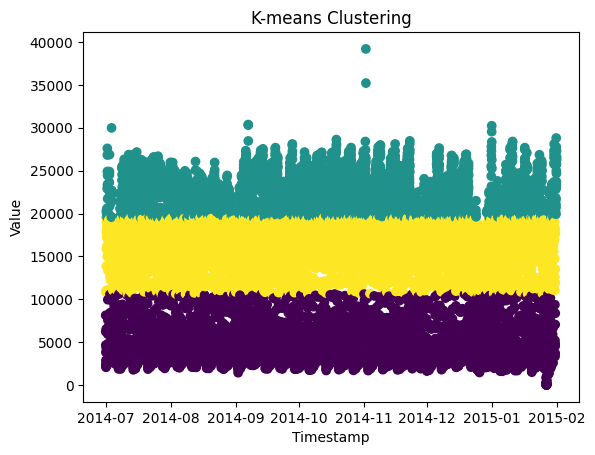

array([[ 4996.9610586 ],
       [22772.71428571],
       [16225.98413679]])

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Standardize the 'value' column
scaler = StandardScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

# Fit K-means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['value_scaled']])

# Plot the data points with their cluster assignments
plt.scatter(df['timestamp'], df['value'], c=df['cluster'])
plt.title('K-means Clustering')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

# Show cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers


## Model Building & Auto ML

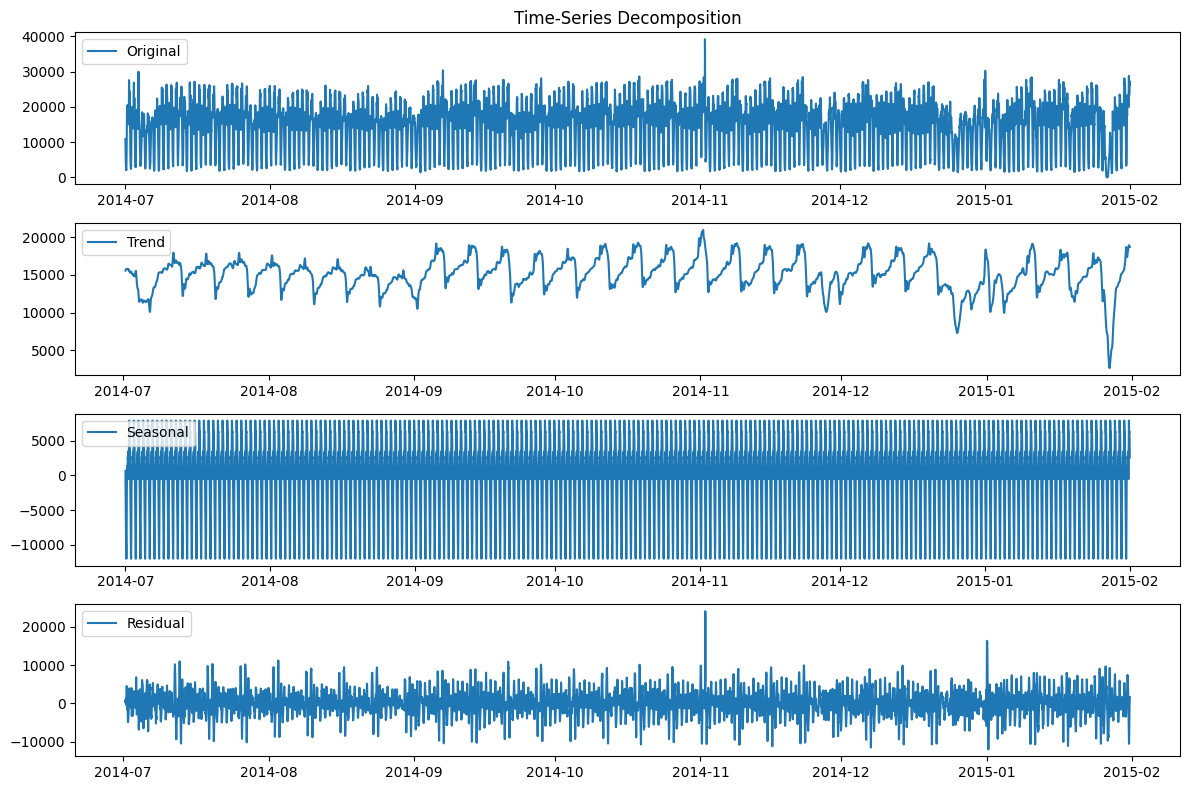

In [5]:
# Apply seasonal decomposition using the correct 'period' parameter
decomposition = seasonal_decompose(df['value'], period=48)  # Assuming 48 time-steps in a day based on 30-min intervals

# Plot the original data, the trend, the seasonality, and the residuals
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['value'], label='Original')
plt.legend(loc='upper left')
plt.title('Time-Series Decomposition')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


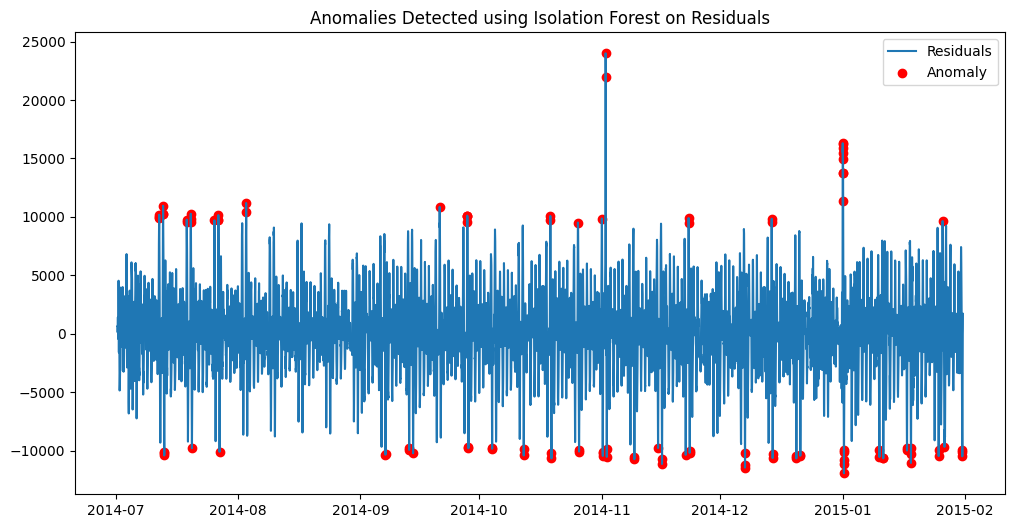

In [6]:
from sklearn.ensemble import IsolationForest

# Remove NaN from residuals after decomposition
residuals = decomposition.resid.dropna()

# Reshape the data for Isolation Forest
residuals_reshaped = residuals.values.reshape(-1, 1)

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
anomalies = isolation_forest.fit_predict(residuals_reshaped)

# Add anomaly labels to the residuals DataFrame
residuals_df = pd.DataFrame(residuals)
residuals_df['anomaly'] = anomalies

# Plot anomalies in the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_df.index, residuals_df['resid'], label='Residuals')
plt.scatter(residuals_df[residuals_df['anomaly'] == -1].index, residuals_df[residuals_df['anomaly'] == -1]['resid'], color='r', label='Anomaly')
plt.legend()
plt.title('Anomalies Detected using Isolation Forest on Residuals')
plt.show()
